In [6]:
push!(LOAD_PATH, pwd()*"/..")
using PyPlot,IM, Dierckx, TwoLevelGraphs, Epidemics#, ContinuusTwoLevel
plt[:rc]("text",usetex=true)

In [2]:
#need to fix finite size effects to get a quantitatively correct answer.
#finite m effects especially

function get_a_distr(a::Function,b::Function,num_points)
    psi1 = IM.get_psi_interp(x -> -1.0*a(x),b,1e-5,0,num_points)
    f(z) = psi1(z)./b(z)
    zz = 0:1/num_points:1
    distr = f(zz)
    distr /= sum(distr)
    spline = Spline1D(zz,distr,k=1,bc="extrapolate")
    distr_fn(x) = evaluate(spline,x)
    return distr_fn
end

function get_a_b(y,delta,m,N)
    y_(z) = y - z*m/N
    a(z) = (1-delta)*(y_(z)-z)
    b(z) = 1/m*(2*delta*z.*(1-z) + (1-delta)*(y_(z).*(1-z) + z.*(1-y_(z))))
    return a,b
end

function get_y_local(delta,y,z)
    y_(z) = y - z*m/N
    return delta*z + (1 - delta)*y_(z)
end

function get_y_sq_local(delta,y,z)
    y_(z) = y - z*m/N
    return delta*z.^2 + (1 - delta)*y_(z).^2
end

function get_number_weight(distr,z,susc=true)
    arr = 0
    if susc
        arr = distr(z).*(1-z)
    else
        arr = distr(z).*z
    end
    return arr/sum(arr) 
end


function get_mean_y_local(y,delta,m,N,susc=true,num_points = 1000)
    a,b = get_a_b(y,delta,m,N)
    distr_fn = get_a_distr(a,b,num_points)
    zz = 0:1/num_points:1
    return sum(get_number_weight(distr_fn,zz,susc).*get_y_local(delta,y,zz))
end

function get_mean_y_sq_local(y,delta,m,N,susc=true,num_points = 1000)
    a,b = get_a_b(y,delta,m,N)
    distr_fn = get_a_distr(a,b,num_points)
    zz = 0:1/num_points:1
    return sum(get_number_weight(distr_fn,zz,susc).*get_y_sq_local(delta,y,zz))
end   


function get_exact_interpolations(delta,m,alpha,beta,N,num_points = 200)

    eps = 1e-5
    yy = collect(eps:1/num_points:1-eps)
    interpolation_order = 1

    yy_sc = [get_mean_y_local(_,delta,m,N,true) for _ in yy]
    yy_inf = [get_mean_y_local(_,delta,m,N,false) for _ in yy]
    yy_sc_sq = [get_mean_y_sq_local(_,delta,m,N,true) for _ in yy]
    yy_inf_sq = [get_mean_y_sq_local(_,delta,m,N,false) for _ in yy]

    s_eff_range = TwoLevelGraphs.get_s_effective_two_level(yy,yy_sc,yy_sc_sq,yy_inf,yy_inf_sq,alpha,beta)
    splus_eff_range = TwoLevelGraphs.get_splus_effective_two_level(yy,yy_sc,yy_sc_sq,yy_inf,yy_inf_sq,alpha,beta)
    s_birth_range = TwoLevelGraphs.get_s_birth_effective_two_level(yy,yy_sc,yy_sc_sq,alpha) 
    s_death_range = TwoLevelGraphs.get_s_death_effective_two_level(yy,yy_inf,beta)

    y_inf_interp = Spline1D(yy,yy_inf,k=interpolation_order,bc="extrapolate")
    y_susc_interp = Spline1D(yy,yy_sc,k=interpolation_order,bc="extrapolate")
    y_sq_inf_interp = Spline1D(yy,yy_inf_sq,k=interpolation_order,bc="extrapolate")
    y_sq_susc_interp = Spline1D(yy,yy_sc_sq,k=interpolation_order,bc="extrapolate")

    s_birth_interp = Spline1D(yy,s_birth_range,k=interpolation_order,bc="extrapolate")
    s_death_interp = Spline1D(yy,s_death_range,k=interpolation_order,bc="extrapolate")
    s_interp = Spline1D(yy,s_eff_range,k=interpolation_order,bc="extrapolate")
    splus_interp = Spline1D(yy,splus_eff_range,k=interpolation_order,bc="extrapolate")
    
    return y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp,s_birth_interp,s_death_interp,s_interp,splus_interp
end




get_exact_interpolations (generic function with 2 methods)

In [20]:
close("all")
k = 40
y_n = 0.1#0.2
c_r = 0.3#0.4
N = 2000#100000#400
n_n = y_n*N#10#80#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
#alpha,beta = 0.0,0.0
println("N=$N, alpha = $alpha, beta = $beta")

#Generate a random startin vector
m = 40#20 number of nodes in a community
n = Int(N/m) 
l = 39#Int(m/2)#10#internal
r = 1#2#Int(m/2)#2 #external

im_wm = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
im_reg = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);

t = TwoLevel(N,m,l,r)
#distribute_randomly(t,n)
# yvals,pvals,s_tl = get_p_reach_theory(t,alpha,beta,N)


delta = l/(l+r)

N=2000, alpha = 0.6666666666666667, beta = 0.06666666666666667


0.975

In [4]:
y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp,
s_birth_interp,s_death_interp,s_interp,
splus_interp = get_exact_interpolations(delta,m,alpha,beta,N,1000);


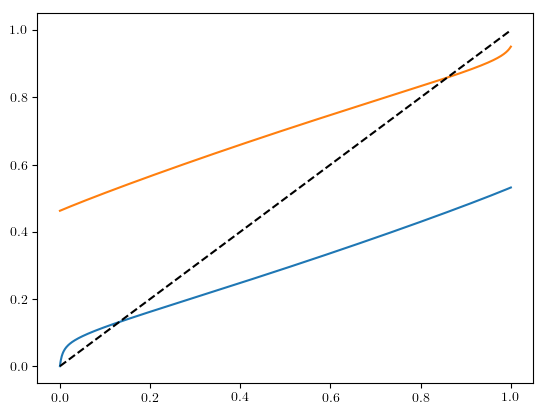

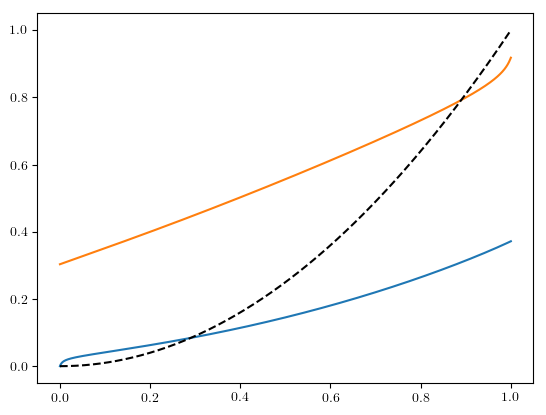

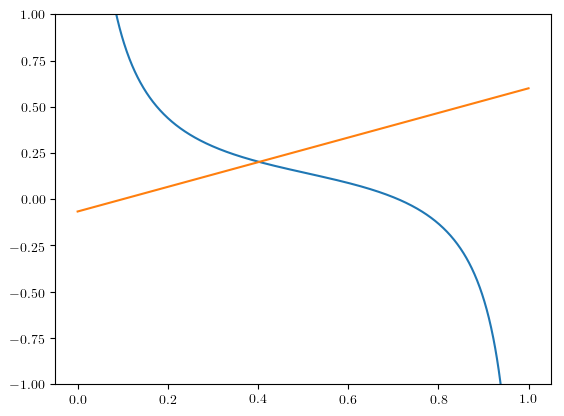

(-1,1)

In [7]:
yy = 0:0.001:1
plot(yy,y_susc_interp(yy))
plot(yy,y_inf_interp(yy))
plot(yy,yy,"--k")
figure()
plot(yy,y_sq_susc_interp(yy))
plot(yy,y_sq_inf_interp(yy))
plot(yy,yy.^2,"--k")
figure()
plot(yy,s_interp(yy))
# plot(yy,s_tl(yy))
plot(yy,alpha*yy-beta)
ylim([-1,1])

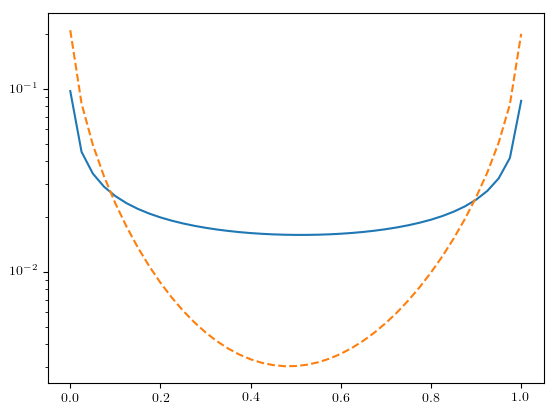

1.0

In [21]:
y = 0.5
num_points = 1000
t.i = N*y

a,b = get_a_b(y,delta,m,N)
distr_fn = get_a_distr(a,b,num_points)
distr_sta = get_stationary_distribution_nlsolve_finite_size(t,alpha,beta)

zz =linspace(0,1,length(distr_sta) )
semilogy(zz,distr_fn(zz)/sum(distr_fn(zz)))
plot(zz,distr_sta/sum(distr_sta),"--")
sum(distr_fn(zz).*collect(1:length(distr_sta)))
sum(distr_fn(zz))
sum(distr_fn(0:0.001:1))

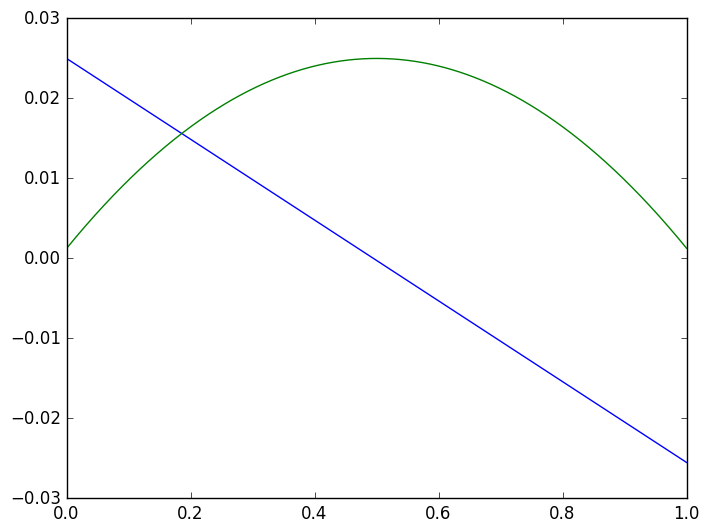

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328e64d50>

In [94]:
zz = 0:0.001:1
plot(zz,a(zz))
plot(zz,b(zz))